## Stanford Online Products

---



---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##What are we going to cover
* Using TensorFlow datasets to download and explore data
* Creating preprocessing function for data
* Batching & preparing datasets for modelling (making our datasets run fast)
* Creating modellings callbacks
* Setting up mixed precision training
* Building a feature extraction model
* Building Fine-tuning the feature extraction
* Viewing trainig results on TensorBoard
* Making predictions on test and unseen real-world data
* Saving the model for future usage

In [ ]:
# Get GPU name (control for mixed precision)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c1a07da2-614f-b904-7075-56db836b4578)


In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-07 08:54:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-07 08:54:48 (78.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# Get all available datasets in TFDS
dataset_list = tfds.list_builders()

# set our target dataset and see if it exist
target_dataset = "stanford_online_products"
print(target_dataset in dataset_list)

True


To get access to the Food101 dataset from the TFDS, we can use the tfds.load() method.

In particular, we'll have to pass it a few parameters to let it know what we're after:

* name (str) : the target dataset (e.g. "food101")
* split (list, optional) : what splits of the dataset we're after (e.g. ["train", "validation"])
the split parameter is quite tricky. See the documentation for more.
*shuffle_files (bool) : whether or not to shuffle the files on download, defaults to False
* as_supervised (bool) : True to download data samples in tuple format ((data, label)) or False for dictionary format
*with_info (bool) : True to download dataset metadata (labels, number of samples, etc)
🔑 Note: Calling the tfds.load() method will start to download a target dataset to disk if the download=True parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [ ]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name = target_dataset,
                                             split = ["train", "test"],
                                             shuffle_files=True,
                                             with_info=True,
                                             )

In [ ]:
# Features of stanford_online_products
ds_info.features

FeaturesDict({
    'class_id': ClassLabel(shape=(), dtype=int64, num_classes=22634),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'super_class_id': ClassLabel(shape=(), dtype=int64, num_classes=12),
    'super_class_id/num': ClassLabel(shape=(), dtype=int64, num_classes=12),
})

In [ ]:
# Get class names
class_names = ds_info.features["super_class_id"].names
class_names

['bicycle',
 'cabinet',
 'chair',
 'coffee_maker',
 'fan',
 'kettle',
 'lamp',
 'mug',
 'sofa',
 'stapler',
 'table',
 'toaster']

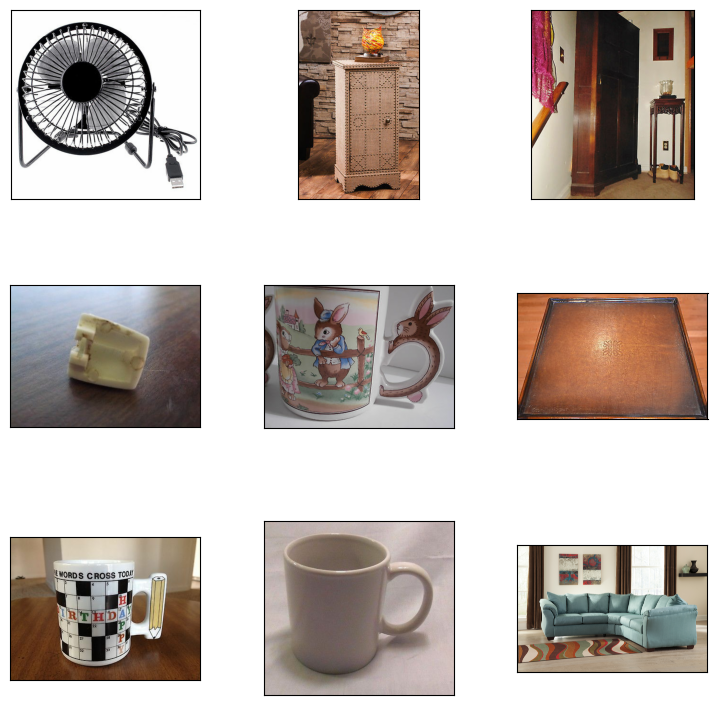

In [ ]:
# let's get same examples from dataset
fig = tfds.show_examples(train_data ,ds_info)

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec={'class_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'super_class_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'super_class_id/num': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
# Because our data is one of _TakeDataset items we need to convert it into a list
train_one_sample = list(train_one_sample)

In [ ]:
import matplotlib.pyplot as plt

# Output info about our training sample
class_id = train_one_sample[0]["class_id"]
image = train_one_sample[0]["image"]
super_class_id = train_one_sample[0]["super_class_id"]
super_class_id_num = train_one_sample[0]["super_class_id/num"]
print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Class id : {class_id}
  Super class id : {super_class_id}
  Super class id num : {super_class_id_num}
  Class Name : {class_names[super_class_id]}
        """)


  Image shape: (395, 500, 3)
  Image dtype: <dtype: 'uint8'>
  Class id : 11136
  Super class id : 11
  Super class id num : 11
  Class Name : toaster
        


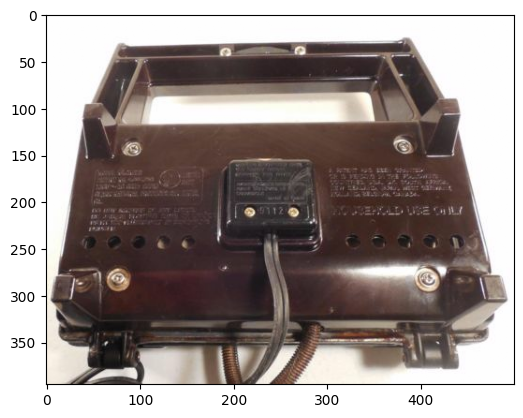

In [ ]:
plt.imshow(image/255)

Checking these you might notice some of the images have different shapes, for example (512, 342, 3) and (512, 512, 3) (height, width, color_channels).

In [ ]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(395, 500, 3), dtype=uint8, numpy=
array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[242, 234, 223],
        [242, 234, 223],
        [242, 234, 223],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[242, 234, 223],
        [242, 234, 223],
        [242, 234, 223],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[242, 234, 223],
        [242, 234, 223],
        [242, 234, 223],
        ...,
        [254, 254, 25

In [ ]:
# What are the min and max values?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=3>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type unit8.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

## Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format, now let's really adhere to our motto.

"Visualize, visualize, visualize!"

Let's plot one of the image samples using matplotlib.pyplot.imshow() and set the title to target class name.

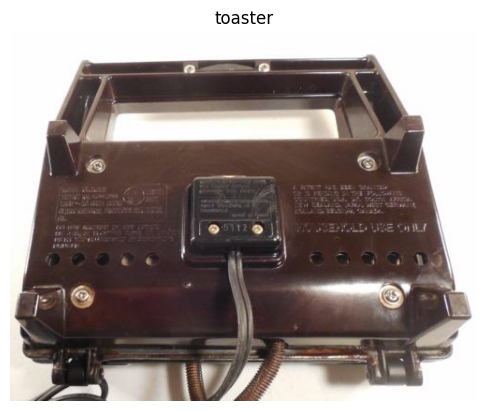

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[super_class_id]) # add title to image by indexing on class_names list
plt.axis(False);

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method tf.keras.utils.image_dataset_from_directory() to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically, our data is currently:

In uint8 data type
Comprised of all differnet sized tensors (different sized images)
Not scaled (the pixel values are between 0 & 255)
Whereas, models like data to be:

In float32 data type
Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
Scaled (values between 0 & 1), also called normalized
To take care of these, we'll create a preprocess_img() function which:

Resizes an input image tensor to a specified size using tf.image.resize()
Converts an input image tensor's current datatype to tf.float32 using tf.cast()
🔑 Note: Pretrained EfficientNetBX models in tf.keras.applications.efficientnet (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "preprocess_img()" function (like the one below) or within your model as a tf.keras.layers.Rescaling layer.

In [ ]:
# Make a function for preprocessing images
def preprocess_img(element, img_shape=224, scale = False): # scale default is false because we are using efficientnetBX
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    class_id = element['class_id']
    image = element['image']
    super_class_id = element['super_class_id']
    super_class_id_num = element['super_class_id/num']

    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    image = tf.cast(image, tf.float32)
    if scale:
      image=image/255.

    return image, super_class_id

In [ ]:
preprocess_img(train_one_sample[0])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ],
         ...,
         [254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ]],
 
        [[254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ],
         ...,
         [254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ]],
 
        [[254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ],
         ...,
         [254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ],
         [254.     , 254.     , 254.     ]],
 
        ...,
 
        [[242.96487, 234.96487, 223.96487],
         [243.     , 235.     , 224.     ]

Our preprocess_img() function above takes class_id ,image, super_class_id and super_class_id_num as input (even though it does nothing to the other parameters) because our dataset is currently in the tuple structure

Let's try our function out on a target image.

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img =preprocess_img(train_one_sample[0])[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")
#train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

Image before preprocessing:
 [[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]]...,
Shape: (395, 500, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our preprocess_img() function is working as expected.

The input image gets converted from uint8 to float32 and gets reshaped from its current shape to (224, 224, 3).

How does it look?

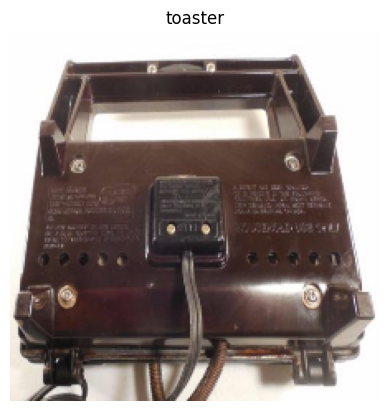

In [ ]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255)
plt.title(class_names[super_class_id])
plt.axis(False);

## Batch & prepare datasets
Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the tf.data API.

📖 Resource: For loading data in the most performant way possible, see the TensorFlow docuemntation on Better performance with the tf.data API.

Specifically, we're going to be using:

* map() - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
* shuffle() - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
* batch() - turns elements of a target dataset into batches (size defined by parameter batch_size)
* prefetch() - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: cache() - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:

* Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our preprocess_img() function)
* shuffle() keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
* For methods with the num_parallel_calls parameter available (such as map()), setting it tonum_parallel_calls=tf.data.AUTOTUNE will parallelize preprocessing and significantly improve speed
* Can't use cache() unless your dataset can fit in memory
Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
This is like saying,

"Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

And now let's check out what our prepared datasets look like.

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:

* tf.keras.callbacks.TensorBoard() - allows us to keep track of our model's training history so we can inspect it later (note: we've created this callback before have imported it from helper_functions.py as create_tensorboard_callback())
* tf.keras.callbacks.ModelCheckpoint() - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [ ]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

## Setup mixed precision training

We touched on mixed precision training above.

However, we didn't quite explain it.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as single-precision floating-point format. The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means half-precision floating-point format. And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the TensorFlow mixed precision guide (I'd highly recommend at least checking out the summary).

Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.

🔑 Note: If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Google Colab), mixed precision won't work (see: "Supported Hardware" in the mixed precision guide for more).

📖 Resource: If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the Wikipedia page (and accompanying resources).

Okay, enough talk, let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the tensorflow.keras.mixed_precision API has made it very easy for us to get started.

First, we'll import the API and then use the set_global_policy() method to set the dtype policy to "mixed_float16".

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

Nice! As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the mixed_precision.global_policy() method.

In [ ]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

Great, since the global dtype policy is now "mixed_float16" our model will automatically take advantage of float16 variables where possible and in turn speed up training.

## Build feature extraction model

Callbacks: ready to roll.

Mixed precision: turned on.

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB4).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

Build a feature extraction model (replace the top few layers of a pretrained model)
Train for a few epochs with lower layers frozen
Fine-tune if necessary with multiple layers unfrozen

To build the feature extraction model (covered in Transfer Learning in TensorFlow Part 1: Feature extraction), we'll:

Use EfficientNetB0 from tf.keras.applications pre-trained on ImageNet as our base model
We'll download this without the top layers using include_top=False parameter so we can create our own output layers
Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
Put together the input, base model, pooling and output layers in a Functional model
Compile the Functional model using the Adam optimizer and sparse categorical crossentropy as the loss function (since our labels aren't one-hot encoded)
Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks
🔑 Note: Since we're using mixed precision training, our model needs a separate output layer with a hard-coded dtype=float32, for example, layers.Activation("softmax", dtype=tf.float32). This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). See the "Building the model" section in the TensorFlow mixed precision guide for more.

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 pooling_layer (GlobalAverag  (None, 1792)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 12)                21516     
                                                                 
 softmax_float32 (Activation  (None, 12)               0         
 )                                                               
                                                                 
Total params: 17,695,339
Trainable params: 21,516
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's "mixed_float16").

We can check this by iterating through our model's layers and printing layer attributes such as dtype and dtype_policy.

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb4 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

layer.name (str) : a layer's human-readable name, can be defined by the name parameter on construction
layer.trainable (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False
layer.dtype : the data type a layer stores its variables in
layer.dtype_policy : the data type a layer computes in
🔑 Note: A layer can have a dtype of float32 and a dtype policy of "mixed_float16" because it stores its variables (weights & biases) in float32 (more numerically stable), however it computes in float16 (faster).

We can also check the same details for our model's base model.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Polic

🔑 Note: The mixed precision API automatically causes layers which can benefit from using the "mixed_float16" dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

## Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
hist_stanford_products_feature_extract = model.fit(train_data,
                                                     epochs=5,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb4_stanford_products_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb4_stanford_products_feature_extract/20230907-085521
Epoch 1/5
1861/1861 [==============================] - 244s 118ms/step - loss: 0.6381 - accuracy: 0.7960 - val_loss: 0.6373 - val_accuracy: 0.7931
Epoch 2/5
1861/1861 [==============================] - 213s 114ms/step - loss: 0.5165 - accuracy: 0.8293 - val_loss: 0.6272 - val_accuracy: 0.7955
Epoch 3/5
1861/1861 [==============================] - 195s 104ms/step - loss: 0.4779 - accuracy: 0.8409 - val_loss: 0.6362 - val_accuracy: 0.7955
Epoch 4/5
1861/1861 [==============================] - 196s 104ms/step - loss: 0.4522 - accuracy: 0.8487 - val_loss: 0.6332 - val_accuracy: 0.7969
Epoch 5/5
1861/1861 [==============================] - 193s 103ms/step - loss: 0.4330 - accuracy: 0.8560 - val_loss: 0.6441 - val_accuracy: 0.7951


In [ ]:
# Evaluate the model
stanford_products_feature_extract_results = model.evaluate(test_data)

1891/1891 [==============================] - 158s 84ms/step - loss: 0.6368 - accuracy: 0.7956


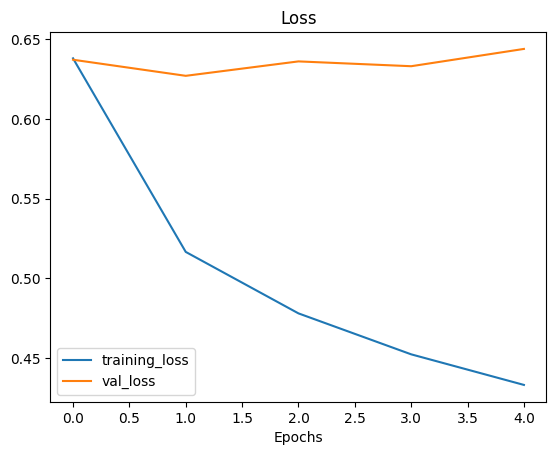

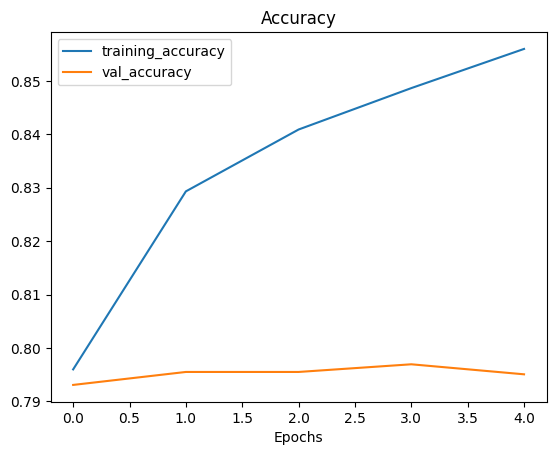

In [ ]:
# plot loss curves
plot_loss_curves(hist_stanford_products_feature_extract)

In [97]:
# let enjoy our model by making prediction
# Let's make a function to orediction  # improved upon helper functions
def pred_and_plot(model,filename, class_names = class_names, real_name=""):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename,scale=False)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img/255)
  if real_name == pred_class:
    plt.title(f"Prediction True: {pred_class} ", color="green")
  else:
    plt.title(f"Prediction False: {pred_class}", color="red")
  plt.axis(False);

  # Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224,scale=False):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape
  (img_shape,img_shape,color_channels=3).

  Args:
    filename (str) : path to target image
    img_shape (int) : height/width dimension of the target image size
    scale (bool) : Scale pixel values from 0-255 to 0-1 or not

  Returns
    Image tensor of shape (img_shape,img_shape,3)
  """
   # Read in the image
  img = tf.io.read_file(filename=filename)

  # Decode image into a tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img,[img_shape,img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values betweem 0 & 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

1/1 [==============================] - 0s 117ms/step


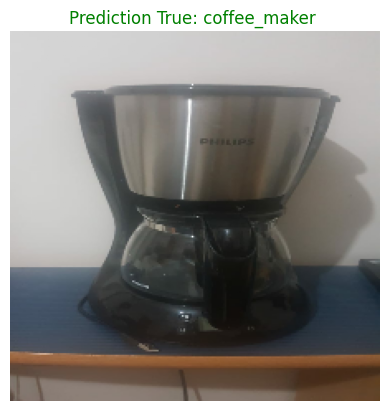

In [98]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/WhatsApp Görsel 2023-09-07 saat 02.49.07.jpg",class_names,"coffee_maker")

1/1 [==============================] - 0s 49ms/step


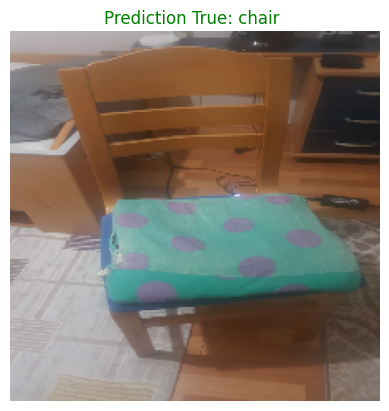

In [100]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/WhatsApp Görsel 2023-09-07 saat 02.50.02.jpg",class_names,"chair")

1/1 [==============================] - 0s 36ms/step


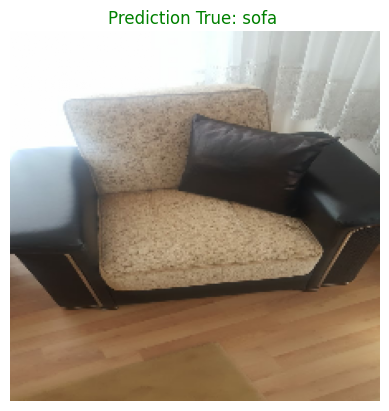

In [99]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/WhatsApp Görsel 2023-09-07 saat 10.41.32.jpg",class_names,"sofa")

In [ ]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/WhatsApp Görsel 2023-09-07 saat 02.58.27.jpg",real_name="lamp")

1/1 [==============================] - 0s 34ms/step


In [ ]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/WhatsApp Görsel 2023-09-07 saat 10.41.32.jpg",real_name="sofa")

1/1 [==============================] - 0s 57ms/step


## WAOOOOWWW!!!!!!

This is amazing our model very clever.

## Load and evaluate checkpoint weights

A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [ ]:
# Load the saved weights
model.load_weights(checkpoint_path)

In [ ]:
# Evaluate the loaded_model
loaded_feature_extraction_results = model.evaluate(test_data)

1891/1891 [==============================] - 158s 83ms/step - loss: 0.6292 - accuracy: 0.7970


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Polic

## Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

🔑 Note: It's worth remembering a traditional workflow for fine-tuning is to freeze a pre-trained base model and then train only the output layers for a few iterations so their weights can be updated inline with your custom data (feature extraction). And then unfreeze a number or all of the layers in the base model and continue training until the model stops improving.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 pooling_layer (GlobalAverag  (None, 1792)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 12)                21516     
                                                                 
 softmax_float32 (Activation  (None, 12)               0         
 )                                                               
                                                                 
Total params: 17,695,339
Trainable params: 21,516
Non-trainab

In [ ]:
# Are any of the layers in our model frozen?
for layer in model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision d

input_layer True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
rescaling_1 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1b_dwconv True float32 <Policy "mixed_float16">


Wonderful, it looks like each layer in our base model is trainable (unfrozen) and every layer which should be using the dtype policy "mixed_policy16" is using it.

🔑 Note: If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.




## A couple more callbacks

In this, fine tuning we will use 4 callbacks

1. Tensorboard
2. ModelCheckPoint
3. EarlyStopping
4. ReduceLROnPlateau

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss does not improve for 4 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                   patience=4
                                                   )

# Create ModelCheckPoint callback to save best model during fine-tuning
checkpoint_path = "/content/drive/MyDrive/TensorFlow_Machine_Learning/Saved_Models/stanford_products_fine_tuning"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_model_only=True,
                                                      monitor="val_loss",
                                                      save_weights_only=True
                                                      )

# Creating learning rate reduction callback
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            factor=0.2,
                                                            patience = 3,
                                                            verbose=1,
                                                            min_lr = 1e-7
                                                            )

Learning rate reduction ready to go!

Now before we start training, we've got to recompile our model.

We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (1e-4 instead of 1e-3).

In [ ]:
# Compile the model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"]
              )


Okay, model compiled.

Now let's fit it on all of the data.

We'll set it up to run for up to 100 epochs.

Since we're going to be using the EarlyStopping callback, it might stop before reaching 100 epochs.

## Fit the fine-tuning Model


In [ ]:
# Start to fine_tune
hist_stanford_products_fine_tuning = model.fit(train_data,
                                               epochs=100,
                                               steps_per_epoch=len(train_data),
                                               validation_data = test_data,
                                               validation_steps = int(0.15 * len(test_data)),
                                               callbacks = [create_tensorboard_callback(dir_name="training_logs",
                                                                                        experiment_name ="efficientnetb4_stanford_products_fine_tuning"),

                                                            model_checkpoint, early_stopping, reduce_learning_rate
                                                                        ]
                                               )

Saving TensorBoard log files to: training_logs/efficientnetb4_stanford_products_fine_tuning/20230907-091934
Epoch 1/100
1861/1861 [==============================] - 749s 341ms/step - loss: 0.3977 - accuracy: 0.8669 - val_loss: 0.5513 - val_accuracy: 0.8228 - lr: 1.0000e-04
Epoch 2/100
1861/1861 [==============================] - 617s 331ms/step - loss: 0.1055 - accuracy: 0.9664 - val_loss: 0.7129 - val_accuracy: 0.8131 - lr: 1.0000e-04
Epoch 3/100
1861/1861 [==============================] - 621s 333ms/step - loss: 0.0593 - accuracy: 0.9814 - val_loss: 0.8390 - val_accuracy: 0.8076 - lr: 1.0000e-04
Epoch 4/100
1861/1861 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9861
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1861/1861 [==============================] - 627s 336ms/step - loss: 0.0435 - accuracy: 0.9861 - val_loss: 0.8730 - val_accuracy: 0.8166 - lr: 1.0000e-04
Epoch 5/100
1861/1861 [==============================] - 627s 33

In [ ]:
# Let's evaluate the model
stanford_products_fine_tuning_results = model.evaluate(test_data)

1891/1891 [==============================] - 161s 85ms/step - loss: 0.8914 - accuracy: 0.8408


Looks like we have improved model performence with 5% difference on feature extraction model via fine-tuning and we saved its weights to google drive

let's make predictions with it

1/1 [==============================] - 0s 55ms/step


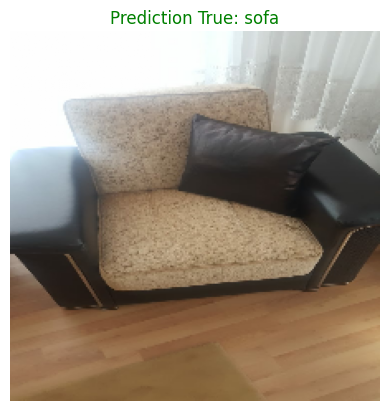

In [ ]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/WhatsApp Görsel 2023-09-07 saat 10.41.32.jpg",real_name="sofa")

1/1 [==============================] - 0s 65ms/step


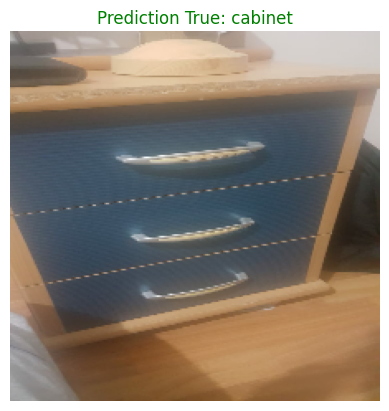

In [ ]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/WhatsApp Görsel 2023-09-07 saat 02.49.09.jpg",real_name="cabinet")

1/1 [==============================] - 0s 58ms/step


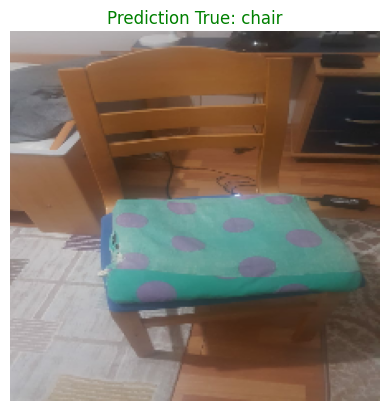

In [ ]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/WhatsApp Görsel 2023-09-07 saat 02.50.02.jpg",real_name="chair")

In [ ]:
class_names

['bicycle',
 'cabinet',
 'chair',
 'coffee_maker',
 'fan',
 'kettle',
 'lamp',
 'mug',
 'sofa',
 'stapler',
 'table',
 'toaster']

1/1 [==============================] - 0s 109ms/step


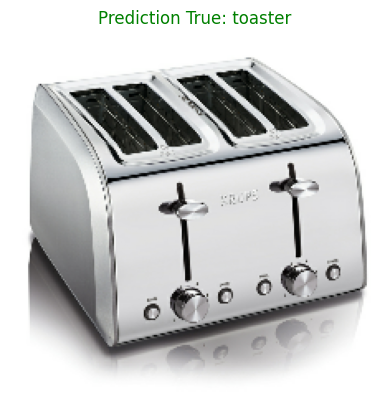

In [ ]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/www.krupsusa.jpg",real_name="toaster")

1/1 [==============================] - 0s 83ms/step


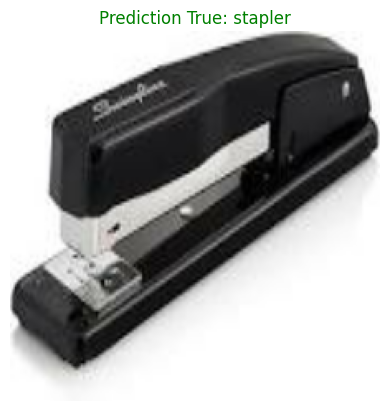

In [ ]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/download.jpg",real_name="stapler")

In [ ]:
class_names

['bicycle',
 'cabinet',
 'chair',
 'coffee_maker',
 'fan',
 'kettle',
 'lamp',
 'mug',
 'sofa',
 'stapler',
 'table',
 'toaster']

1/1 [==============================] - 0s 110ms/step


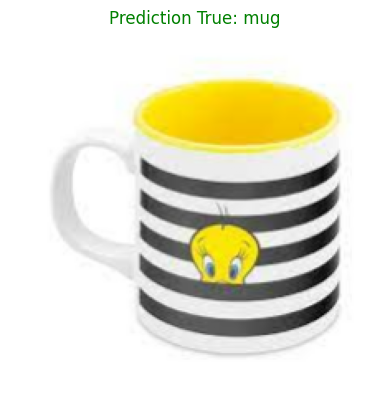

In [ ]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/mug.jpg",real_name="mug")

1/1 [==============================] - 0s 57ms/step


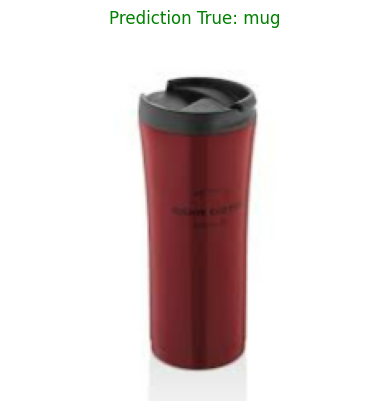

In [77]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/termos.jpg",real_name="mug")

In [78]:
class_names

['bicycle',
 'cabinet',
 'chair',
 'coffee_maker',
 'fan',
 'kettle',
 'lamp',
 'mug',
 'sofa',
 'stapler',
 'table',
 'toaster']

1/1 [==============================] - 0s 65ms/step


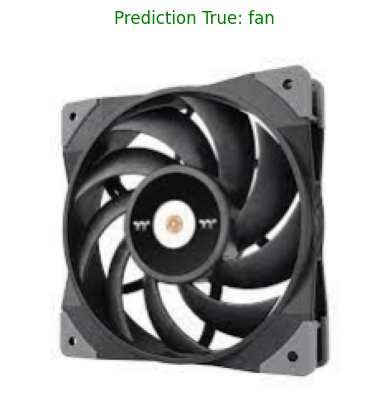

In [81]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/fan.jpg",real_name="fan")

1/1 [==============================] - 0s 100ms/step


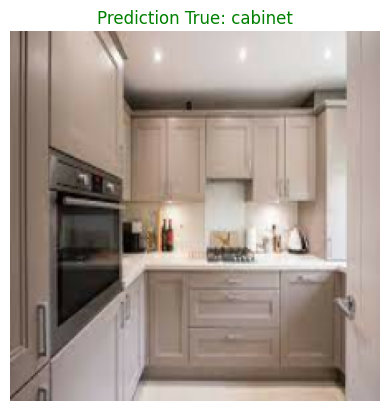

In [82]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/cabinet.jpg",real_name="cabinet")

1/1 [==============================] - 0s 63ms/step


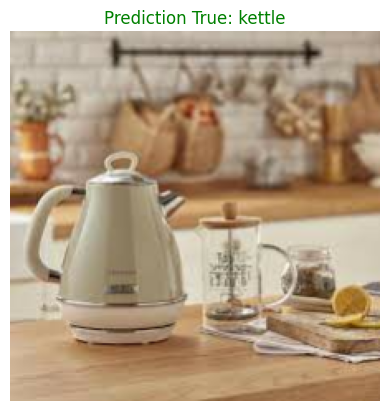

In [83]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/kettle.jpg",real_name="kettle")

1/1 [==============================] - 0s 53ms/step


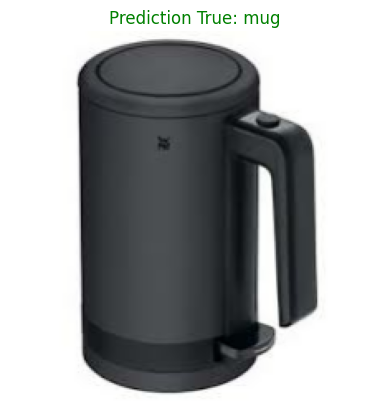

In [84]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/images.jpg",real_name="mug")

In [85]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/kettle_1.jpg",real_name="kettle")

1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 56ms/step


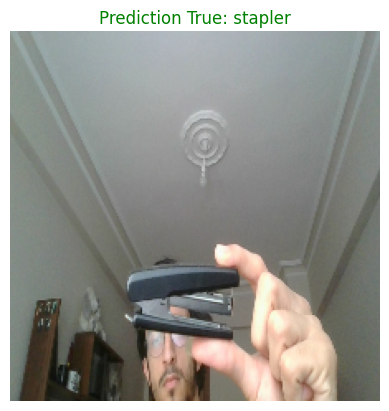

In [86]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/WIN_20230907_13_45_19_Pro.jpg",real_name="stapler")

1/1 [==============================] - 0s 61ms/step


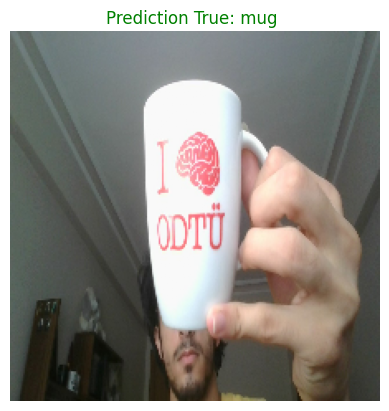

In [103]:
pred_and_plot(model,"/content/drive/MyDrive/TensorFlow_Machine_Learning/stanfard_model_test_samples/WIN_20230907_13_55_05_Pro.jpg",real_name="mug")

We have completed standford online products estimation notebook with 84% accuracy.

And all of above predicts images is taken from google unseen data. Our model accomplished all of them

We saved our model weights to google drive.Whenever we need it, we can load and use our successful load